Authors: Laurynas Varnas, Marco Gabriel, Nicolau Oliver Burwitz

Link to the repository with all resources: https://github.com/ShadowDragon5/CV_project

In [1]:
from bisect import bisect
from pathlib import Path
import itertools

from cv2.typing import MatLike
from scipy.optimize import fsolve
from sympy import Matrix, Symbol, lambdify
import cv2
import numpy as np

from google.colab.patches import cv2_imshow as img_show


# def img_show(img, title="Title") -> None:
#     """Helper function to display the image and wait for input"""
#     cv2.imshow(title, img)

#     while cv2.getWindowProperty(title, cv2.WND_PROP_VISIBLE) >= 1:
#         key = cv2.waitKey(100)

#         # q key closes the window
#         if (key & 0xFF) == ord("q"):
#             cv2.destroyAllWindows()
#             break

## Preprocessing

This part filters the video for frames showing the table in the desired perspective.

We noticed, that almost all target frames contain a scoreboard (the names on yellow background and the white and blue area) in the bottom of the frame. We handpicked the location of this scoreboard and compared this part of all frames to the sample frame. We include all frames in the filtered video for which difference of this part to the sample image is smaller than a handpicked threshold.
We observed some misclassifications, as for example in repeated video segments the score is not shown. Consequently, these segments are not contained in our filtered video. On the other hand, there are occasionally some trajectories drawn on the screen in white while the scoreboard is shown, so these frames are included. However, we suppose these cases are mere edge-cases and our filtering by the scoreboard works well enough.

In [2]:
class VideoReader:
    def __init__(self, video_path: str | Path, max_count=-1) -> None:
        self.count = max_count
        self.video = cv2.VideoCapture(str(video_path))

        if not self.video.isOpened():
            print("Error openning video file")

    def __iter__(self):
        return self

    def __next__(self) -> MatLike:
        _, frame = self.video.read()

        if frame is None or self.count == 0:
            self.video.release()
            raise StopIteration

        self.count -= 1
        return frame

In [3]:
def extract_score_tag(frame: MatLike) -> MatLike:
    """Return the score tag coordinates """
    width, height, _ = frame.shape
    # Resolution of 'WSC\ sample.png'
    baseline_width, baseline_height = (720, 1280)

    # Relevant rang minus one pixel border due to blurring spill
    # Handpicked image coordinates of 'WSC\ sample.png'
    a_x, a_y = (651, 320)  # Upper left corner of score tag
    b_x, b_y = (679, 960)  # Lower right corner of score tag

    # Rescale coordinates to frame resolution
    r_x = width / baseline_width  # width scaling ratio
    r_y = height / baseline_height  # height scaling ratio
    a_x, a_y = (int(np.ceil(a_x * r_x)), int(np.ceil(a_y * r_y)))
    b_x, b_y = (int(np.floor(b_x * r_x)), int(np.floor(b_y * r_y)))

    # Extract score tag
    score_tag = frame[a_x:b_x, a_y:b_y]

    return score_tag

In [4]:
def compare_score_tag(baseline, sample, tolerance=0.15) -> bool:
    """Resolution agnostic comparison of score tags"""
    baseline_width, baseline_height, _ = baseline.shape
    sample_width, sample_height, _ = sample.shape

    # Compute smallest resolution
    width, height = (
        min(baseline_width, sample_width),
        min(baseline_height, sample_height),
    )

    # Resize inputs
    baseline_small = cv2.resize(baseline, (height, width))
    sample_small = cv2.resize(sample, (height, width))

    # Compute abs diff and sum up as score
    diff = cv2.absdiff(baseline_small, sample_small)
    diff_score = np.sum(diff)

    # Tolerance on error (max allowed score)
    threshold = tolerance * (width * height * 3) * 255

    return diff_score < threshold

# Feature Detection

## Static analysis of sample frame

From the sample frame we extract known features with known world coordinates, namely: the green to brown edges of the playing area, the baulk line, and the center of the yellow brown green and blue balls. We excluded the pink, white and black balls due to concerns in color filtering.

### Table edges and baulk line

To detect these features, we relied heavily on knowing their precise color ranges. By examining the sample frame on a image processing program, we handpicked the ranges in HSL colorspace. To detect the green/grown edge, we used small dilations of the regions of both colors to force an overlap. Once we obtained a binary image representing the lines we desired, we used our customized Hough line transform to obtain the theta angle and rho distance form the origin of the lines.


In [5]:
def hough_lines(binary_img, rho_step=0.5, theta_step=0.5, num_lines=4):
    """
    Hough line implementation
    original source: https://github.com/alyssaq/hough_transform
    """
    width, height = binary_img.shape
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90, 90 - theta_step, theta_step))
    diag_len = np.ceil(np.sqrt(width**2 + height**2))  # max_dist
    rhos = np.arange(-diag_len, diag_len, rho_step)

    # Cache some resuable values
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((len(rhos), len(thetas)))
    # (row, col) indexes to edges
    y_idxs, x_idxs = np.nonzero(binary_img)
    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            # Calculate rho
            rho = x * cos_theta[t_idx] + y * sin_theta[t_idx]
            r_idx = bisect(
                rhos, rho, hi=len(rhos) - 1
            )  # which in rhos is the closest one
            accumulator[r_idx, t_idx] += 1

    # Non maxima supression
    # num_lines = 4 #Assumption on the number of lines we have
    lines = []
    for i in range(num_lines):
        rho_max_i, theta_max_i = np.unravel_index(
            np.argmax(accumulator), accumulator.shape
        )
        lines.append((rhos[rho_max_i], thetas[theta_max_i]))
        r_window = (
            20  # Assumption on the lines we want to detect having notably different rho
        )
        t_window = 20  # Lines we want to detect have different theta
        for r_w in range(-r_window, r_window + 1):
            r_w_mod = min(max((rho_max_i + r_w), 0), len(rhos))
            for t_w in range(-t_window, t_window + 1):
                t_w_mod = (theta_max_i + t_w) % len(thetas)
                # Supress maxima in neibourhood
                accumulator[r_w_mod, t_w_mod] = 0

    return lines

To find line intersections the following linear system was used:
$\begin{bmatrix} \cos\theta_1 & \sin\theta_1 \\ \cos\theta_2 & \sin\theta_2 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} \rho_1 \\ \rho_2 \end{bmatrix}$

In [6]:
def table_edges_detection(frame_BGR: MatLike) -> (MatLike, list):
    """
    Function that detects the hardcoded green and brown colors
    and computes the edges where the colors touch. It then
    computes the most likely 4 straight lines that fit the edges
    """
    width, height, _ = frame_BGR.shape

    frame_HSV = cv2.cvtColor(frame_BGR, cv2.COLOR_BGR2HSV)

    # CV2 HSV ranges: Hue from 0 to 180, Saturation form 0 to 100, Value from 0 to 100

    # Filter green color
    # NOTE: Hard-coded green HSV value
    GREEN_HSV_LOW = np.array([55, 100, 50])
    GREEN_HSV_HIGH = np.array([65, 255, 220])
    frame_green = cv2.inRange(frame_HSV, GREEN_HSV_LOW, GREEN_HSV_HIGH)

    # Filter brown color
    # NOTE: Hard-coded brown HSV value
    BROWN_HSV_LOW = np.array([0, 0, 20])
    BROWN_HSV_HIGH = np.array([5, 200, 150])
    frame_brown_1 = cv2.inRange(frame_HSV, BROWN_HSV_LOW, BROWN_HSV_HIGH)

    # NOTE: Hard-coded another brown HSV value
    BROWN_HSV_LOW = np.array([130, 0, 20])
    BROWN_HSV_HIGH = np.array([180, 200, 150])
    frame_brown_2 = cv2.inRange(frame_HSV, BROWN_HSV_LOW, BROWN_HSV_HIGH)

    frame_brown = cv2.bitwise_or(frame_brown_1, frame_brown_2)

    # Dilate green and brown so that they overlap
    # NOTE: Hard-coded value
    KERNEL_SMALL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    brown_dilate = cv2.dilate(frame_brown, KERNEL_SMALL)
    KERNEL_VERY_SMALL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    green_dilate = cv2.dilate(frame_green, KERNEL_VERY_SMALL)

    # Get a thin edge of the green playing area
    # NOTE: Hard-coded value
    KERNEL_VERY_SMALL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    green_gradient = cv2.morphologyEx(
        green_dilate, cv2.MORPH_GRADIENT, KERNEL_VERY_SMALL
    )

    # Intersect the green edge with the brown mask to obtain green/brow edges
    edges_green_brown = cv2.bitwise_and(green_gradient, brown_dilate)

    # Compute lines that fit the edges
    lines = hough_lines(edges_green_brown, num_lines=4)

    # NOTE: order is important
    l_top = lines[0]
    l_bot = lines[1]
    l_rig = lines[2]
    l_lef = lines[3]

    # Construct the A and b matrices
    def A_b(rho1, theta1, rho2, theta2):
        A = np.array(
            [
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)],
            ]
        )
        b = np.array([[rho1, rho2]]).T
        return A, b

    # find the intersection points
    top_left = np.linalg.solve(*A_b(*l_top, *l_lef)).T.squeeze()
    top_right = np.linalg.solve(*A_b(*l_top, *l_rig)).T.squeeze()
    bottom_left = np.linalg.solve(*A_b(*l_bot, *l_lef)).T.squeeze()
    bottom_right = np.linalg.solve(*A_b(*l_bot, *l_rig)).T.squeeze()

    return np.array(
        [[top_left, top_right, bottom_right, bottom_left]],
        dtype=np.int32,
    )

In [7]:
def detect_baulk_line(frame: MatLike) -> tuple:
    """
    Function that detects the lines markings on the table
    frame: BGR image
    returns: baulk line in (rho, theta) format
    """
    # Filter white color
    white_HSL_low = np.array([9, 113, 2])  # Hardcoded white HSL value
    brown_HSL_high = np.array([13, 128, 10])
    frame_white = cv2.inRange(frame, white_HSL_low, brown_HSL_high)

    baulk_line = hough_lines(frame_white, num_lines=1)

    return baulk_line[0]

### Ball centers

Due to some of the balls being completely unoccluded in the sample frame, we decided to detect their centers. To compute the center of the ball, again we filtered for a specific range but only on the hue channel. This yielded a very precise contour of the balls, as the playing area is very consistent in hue. Then we applied an erosion using as kernel roughly the same shape as the balls themselves, but slightly smaller. This resulted in their centers.

In [8]:
def get_ball_centers(frame: MatLike) -> dict:
    """
    frame: BGR image to detect the balls in
    returns: dictionary of ball colors and their centers {color: [x, y], ...}
    """
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # NOTE: Hard-coded values
    ranges = {
        "yellow": [20, 35],
        "brown": [15, 23],
        "green": [71, 85],
        "blue": [85, 110],
    }
    KERNEL_BALL_SIZE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))

    centers = {}
    for color, (lower, upper) in ranges.items():
        ball = cv2.inRange(img_hsv[:, :, 0], np.array([lower]), np.array([upper]))
        eroded = cv2.erode(ball, KERNEL_BALL_SIZE)
        # get the average (middle) pixel x and y coordinate of the eroded ball
        centers[color] = np.mean(np.argwhere(eroded != 0), axis=0, dtype=int)[::-1]

    return centers

### DLT
Given the previous features correspondences of image coordinates and world coordinates, we computed the camera matrix using the DLT algorithm. Both as specified in the theory slides and the normalized DLT algorithm. This latter one resulted in more precise results. From this step we also computed the camera position in world coordinates.



In [9]:
def normalize_points_2D(points):
    centroid = np.mean(points, axis=0)
    centered_points = points - centroid
    mean_distance = np.mean(np.sqrt(np.sum(centered_points**2, axis=1)))
    scale = np.sqrt(2) / mean_distance
    T = np.array(
        [[scale, 0, -scale * centroid[0]], [0, scale, -scale * centroid[1]], [0, 0, 1]]
    )
    normalized_points = (T @ np.hstack((points, np.ones((points.shape[0], 1)))).T).T
    return normalized_points[:, :2], T


def normalize_points_3D(points):
    centroid = np.mean(points, axis=0)
    centered_points = points - centroid
    mean_distance = np.mean(np.sqrt(np.sum(centered_points**2, axis=1)))
    scale = np.sqrt(3) / mean_distance
    T = np.array(
        [
            [scale, 0, 0, -scale * centroid[0]],
            [0, scale, 0, -scale * centroid[1]],
            [0, 0, scale, -scale * centroid[2]],
            [0, 0, 0, 1],
        ]
    )
    normalized_points = (T @ np.hstack((points, np.ones((points.shape[0], 1)))).T).T
    return normalized_points[:, :3], T


def DLT_normalized(X_in, x_in):
    """
    Computes the Camera coordinates -> World coordinates matrix using normalized DLT alg
    X: Points in 3D (world coordinates)
    x: Corresponding points in 2D (camera coordinates)
    """
    # Normalize the points
    X_normalized, T_X = normalize_points_3D(X_in)
    x_normalized, T_x = normalize_points_2D(x_in)

    # Convert to homogeneous coordinates
    X = np.hstack((X_normalized, np.ones((len(X_normalized), 1))))
    x = np.hstack((x_normalized, np.ones((len(x_normalized), 1))))

    # Building the matrix A that contains all correspondences
    # relating them to the camera parameter vector p
    A = np.empty((0, 12), int)
    for i in range(len(X)):
        x_i, y_i, w_i = x[i]
        zeros = np.zeros((1, 4))
        A_i = np.block(
            [
                [zeros, -w_i * X[i], y_i * X[i]],
                [w_i * X[i], zeros, -x_i * X[i]],
                [-y_i * X[i], x_i * X[i], zeros],
            ]
        )
        A = np.vstack((A, A_i))

    # Solving x = PX by computing single value decomposition of A
    # It automatically deals with overdetermined system of equations
    U, S, Vh = np.linalg.svd(A)
    p = Vh[-1]
    P_normalized = p.reshape(3, 4)

    # Denormalize the projection matrix
    P = np.linalg.inv(T_x) @ P_normalized @ T_X
    P = P / P[-1, -1]

    return P

## Detect Highlight

To detect the image coordinates of the highlight for each frame of the video, we use the detect_highlight function.

First, we select the pixels of the video frame that have the color of the balls. This gives us masks for each color of balls. We handpicked the ranges for each ball color.
Our current selection yields some false positives of red balls on the pink ball, and the distinction of the white and yellow ball, as well as the detection of the black ball, are not as robust as we hoped for.

We then erode these masks to remove any noise (for example, the shadows of all balls have the same color as the black ball) and dilate them to make them big enough to encompass the highlight. We then only select the largest connected group of pixels that morphologically resembles a ball to further eliminate any noise that made it through the eroding step, such as the players wearing a black shirt walking into the frame. An exception to this step is the red mask. As there are multiple red balls we cannot select the largest group, so this entire step is skipped.

The next step is to find the highlights. We check for every pixel in a given mask if the above neighbour is bright enough to be a highlight. This yields us the lower edge of the highlights. We then dilate these masks such that they cover the whole specular.

In these dilated masks we then select all bright pixels that we consider part of the highlight. We noticed, that the highlight has different colors for different balls, so we differentiate here. For example, the highlight on the black ball is much darker than on the others.
Finally, using these highlight-pixels, we calculate the exact position of the reflection by getting the position of the lowest pixel as the y coordinate and the mena of the highlight pixels as the x coordinate. We chose to get the lower end of the reflection as this might be detectable more exactly than the middle. We handle the red balls in a similar fashion by just calculating the location for each group of pixels in the mask.


In [10]:
# NOTE: Hard-coded vaues:
# Colors of the balls
COLORS = ["blue", "red", "pink", "brown", "yellow", "green", "white", "black"]
COLOR_STR_TO_BGR = {
    "red": (0, 0, 255),
    "blue": (255, 0, 0),
    "pink": (130, 130, 255),
    "green": (0, 255, 0),
    "black": (50, 50, 50),
    "brown": (20, 70, 130),
    "yellow": (0, 190, 250),
}
# Color of the blue ball
MAX_BLUE = (25, 255, 255)
MIN_BLUE = (10, 0, 30)
# Color of the red balls
MAX_RED = (130, 255, 190)
MIN_RED = (110, 170, 0)
# Color of the pink ball
MAX_PINK = (130, 255, 255)
MIN_PINK = (110, 0, 200)
# Color of the brown ball
MAX_BROWN = (110, 255, 150)
MIN_BROWN = (90, 0, 0)
# Color of the yellow ball
MAX_YELLOW = (100, 255, 255)
MIN_YELLOW = (90, 0, 150)
# Color of the green ball
MAX_GREEN = (50, 255, 255)
MIN_GREEN = (30, 0, 0)
# Color of the white ball
MAX_WHITE = (90, 255, 255)
MIN_WHITE = (70, 0, 150)
# Color of the black ball
MAX_BLACK = (255, 255, 50)
MIN_BLACK = (0, 1, 0)
# Color of the highlight/specular
MIN_HIGHLIGHT = (0, 0, 245)
# This value is used to detect the larger specular area so is more tolerant
MAX_HIGHLIGHT_REGION = (255, 255, 255)
MAX_HIGHLIGHT = (255, 120, 255)
# Color of the highlight/specular on different balls:
MIN_HIGHLIGHT_BLACK = (0, 0, 145)
MAX_HIGHLIGHT_YELLOW = (255, 200, 255)
MAX_HIGHLIGHT_PINK = (255, 70, 255)
# Number of Iterations to erode the initial ball masks
ERODE_ITERATIONS = 2
ERODE_ITERATIONS_BLACK = 4
# Number of Iterations to dilate the initial ball masks
DILATE_ITERATIONS = 2

In [11]:
def get_neighbours(point):
    """
    Returns the neighbour coordinates of a pixel ignoring diagonals
    """
    x, y = point
    return [[x, y], [x + 1, y], [x - 1, y], [x, y + 1], [x, y - 1]]

In [12]:
def merge_groups(groups, ignore_groups):
    """
    Takes a list of lists containing coordinates of pixels.
    These lists are called groups.
    Merges 2 groups if they contain neighbouring pixels.
    """
    ignore_groups = []  # ignore already processed groups to improve performance
    for current_index, current_group in enumerate(groups):
        if current_index in ignore_groups:
            continue
        for point in current_group:
            neighbours = get_neighbours(point)
            for index, group in enumerate(groups):
                if index == current_index:
                    continue
                # check for every pixel if it has neighbours that belong to another group
                exists = any(neighbour in group for neighbour in neighbours)
                if exists:
                    # merge the 2 groups
                    groups[index] = groups[index] + groups[current_index]
                    groups.pop(current_index)
                    return groups, True, ignore_groups
        ignore_groups += [current_index]
    return groups, False, ignore_groups

In [13]:
def get_groups(mask, n=1):
    """
    Given a mask, returns the n pargest patches/groups of pixels with value 255.
    """
    # NOTE: Hard-coded value of the mask's value
    candidates = np.where(mask == 255)

    groups = []
    for px, py in zip(candidates[0], candidates[1]):
        added = False
        neighbours = get_neighbours((px, py))
        # check if the pixel belongs to an already created group
        for index, group in enumerate(groups):
            exists = any(elem in group for elem in neighbours)
            if exists:
                groups[index] = groups[index] + [[px, py]]
                added = True
        if not added:  # create new group
            groups += [[[px, py]]]

    # merge neighbouring groups, this is necessary as the previous step may have one patch into multiple groups
    ignore_groups = []
    merged = True
    while merged:
        groups, merged, ignore_groups = merge_groups(groups, ignore_groups)
    groups = sorted(groups, key=len, reverse=True)
    return groups


def matches_window(frame, lower_mask, color_min_upper, color_max_upper):
    """
    Checks for every pixel in a given mask if the above neighbor is withing a specified range.
    Returns the coordinates of the upper pixels of such matchings.
    """
    lower = lower_mask
    upper = cv2.inRange(frame, color_min_upper, color_max_upper)

    lower_matched_x, lower_matched_y = np.where(lower == 255)

    matchings = []
    for lower_candidate_x, lower_candidate_y in zip(lower_matched_x, lower_matched_y):
        if lower[lower_candidate_x, lower_candidate_y] > 0:
            if upper[lower_candidate_x - 1, lower_candidate_y] == 255:
                matchings.append((lower_candidate_x - 1, lower_candidate_y))
        else:
            print("image window out of bounds")
    return matchings


def morphological_filter(group, dil_iter=0, ero_iter=0):
    # remove duplicates (uncaught bug)
    group.sort()
    group = list(group for group, _ in itertools.groupby(group))

    # Area filter

    # create zero's matrix as background
    ball_template = np.zeros((4 * dil_iter + 20, 4 * dil_iter + 20))

    # insert template ball
    ball_template[
        2 * dil_iter : 2 * dil_iter + 20, 2 * dil_iter : 2 * dil_iter + 20
    ] = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))

    ball_template = cv2.erode(ball_template, None, iterations=ero_iter)
    ball_template = cv2.dilate(ball_template, None, iterations=dil_iter + ero_iter)

    area_ball = np.sum(ball_template)
    if len(group) > area_ball * 1.2:
        tmp = np.zeros((720, 1280))
        for [x, y] in group:
            if tmp[x, y] == 0:
                tmp[x, y] = 255
        return False

    # Bounding box (orthogonal diameter)
    diameter_ball = 20 + 2 * dil_iter
    group_x = [pixel[0] for pixel in group]
    group_y = [pixel[1] for pixel in group]
    diameter_x = np.max(group_x) - np.min(group_x)
    diameter_y = np.max(group_y) - np.min(group_y)
    diameter_group = max(diameter_x, diameter_y)
    if diameter_group > diameter_ball * 1.2:
        print("Diameter fail")
        return False

    return True


def visualize_points(image, points, color):
    """
    Takes an image and paints some points in specified color on top
    """
    image = image.copy()
    image = np.zeros((image.shape[0], image.shape[1], 3))
    for x, y in points:
        image[x, y] = color
    return image


def detect_highlight(frame, version="max"):
    """
    Given a frame, returns the coordinates of the highlights/speculars on all balls.
    Version="max": returns the lower edge of the highlight
    Version="mean": returns the middle of the highlight
    Return structure:
    [(color_as_string, (x_coord, y_coord), mask_of_highlight), ...]
    for red, the second element is a list of coordinates, as there may be multiple red balls:
    [(x_coord_1, y_coord_1), (x_coord_2, y_coord_2), ...]
    """
    # convert frame to HSV for easier color detection
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    mask_blue = cv2.inRange(hsv_frame, MIN_BLUE, MAX_BLUE)
    mask_red = cv2.inRange(hsv_frame, MIN_RED, MAX_RED)
    mask_pink = cv2.inRange(hsv_frame, MIN_PINK, MAX_PINK)
    mask_brown = cv2.inRange(hsv_frame, MIN_BROWN, MAX_BROWN)
    mask_yellow = cv2.inRange(hsv_frame, MIN_YELLOW, MAX_YELLOW)
    mask_green = cv2.inRange(hsv_frame, MIN_GREEN, MAX_GREEN)
    mask_white = cv2.inRange(hsv_frame, MIN_WHITE, MAX_WHITE)
    mask_black = cv2.inRange(hsv_frame, MIN_BLACK, MAX_BLACK)

    raw_masks = [
        mask_blue,
        mask_red,
        mask_pink,
        mask_brown,
        mask_yellow,
        mask_green,
        mask_white,
        mask_black,
    ]
    masks = []

    # Dilate all masks and get largest patch:
    for index, mask in enumerate(raw_masks):
        erode_iterations = ERODE_ITERATIONS
        dilate_iterations = DILATE_ITERATIONS
        if index == 1:  # red
            masks.append(mask)
            continue  # Not parsing red as there are multiple red balls
        if index == 7:  # black
            erode_iterations = ERODE_ITERATIONS_BLACK
        eroded_mask = cv2.erode(mask, None, iterations=erode_iterations)
        dilated_mask = cv2.dilate(
            eroded_mask, None, iterations=dilate_iterations + erode_iterations
        )

        groups = get_groups(dilated_mask, dilate_iterations - erode_iterations)

        # Filter groups
        groups = [
            group
            for group in groups
            if morphological_filter(group, dilate_iterations, erode_iterations)
        ]
        if len(groups) == 0:
            print("No ball found")
            continue
        largest_group = groups[0]
        new_mask = np.zeros(mask.shape)
        for point in largest_group:
            new_mask[point[0], point[1]] = 255
        masks.append(new_mask)

    highlight_masks = []

    for mask in masks:
        matchings = matches_window(
            hsv_frame, mask, MIN_HIGHLIGHT_BLACK, MAX_HIGHLIGHT_REGION
        )
        matchings_visualized = visualize_points(mask, matchings, (0, 0, 255))
        highlight_masks.append(matchings_visualized)

    highlight_masks_diluted = []
    for index, highlight in enumerate(highlight_masks):
        eroded_mask = cv2.erode(highlight, None, iterations=0)
        dilated_mask = cv2.dilate(eroded_mask, None, iterations=4)
        highlight_masks_diluted.append(dilated_mask)

    results = []
    for index, highlight in enumerate(highlight_masks_diluted):
        # at these locations, check the HSV frame for bright pixels
        black_pixels = np.where(highlight[:, :, 2] != 255)
        cropped_frame = hsv_frame.copy()
        cropped_frame[black_pixels] = [0, 0, 0]

        min_highlight = MIN_HIGHLIGHT
        max_highlight = MAX_HIGHLIGHT
        if COLORS[index] == "black":
            min_highlight = MIN_HIGHLIGHT_BLACK
        elif COLORS[index] == "yellow":
            max_highlight = MAX_HIGHLIGHT_YELLOW
        elif COLORS[index] == "pink":
            max_highlight = MAX_HIGHLIGHT_PINK

        highlight_pixels = cv2.inRange(cropped_frame, min_highlight, max_highlight)
        high = cv2.cvtColor(highlight_pixels, cv2.COLOR_GRAY2BGR)

        highlight_coordinates = np.where(highlight_pixels > 0)

        if len(highlight_coordinates[0]) == 0:
            continue

        if COLORS[index] == "red":
            # get n biggest highlight
            groups = get_groups(highlight_pixels)
            largest_groups = groups[:15]
            # get mean per group
            highlight_mean = []
            highlight_max = []
            new_mask = np.zeros(highlight_pixels.shape)
            for group in largest_groups:
                group_mean = np.mean(group, axis=0)
                highlight_mean.append(group_mean)
                highlight_max.append(
                    (np.max(np.array(group)[:, 0], axis=0), group_mean[1])
                )
                for point in group:
                    new_mask[point[0], point[1]] = 255
                    highlight_pixels = new_mask

        else:
            highlight_mean = np.mean(highlight_coordinates, axis=1)
            highlight_max = [(max(highlight_coordinates[0]), highlight_mean[1])]

        highlight_mean = np.array(highlight_mean)
        if (
            len(highlight_mean) > 1 and (highlight_mean == highlight_mean).all()
        ):  # check that the mean is not NaN
            if version == "max":
                results.append((COLORS[index], highlight_max, highlight_pixels))
            else:
                results.append((COLORS[index], highlight_mean, highlight_pixels))

    return results

## Wold coordinates of balls

From the image coordinates of the highlights, we computed the world coordinates of the center of the balls by solving the geometry problem of the specular light reflection. This proved to be a bit imprecise and very sensitive to noise in the DLT. We generated a symbolic expression that related the position of the center of the ball with the distance of the Highlight to the camera in world coordinates. We solved this non-linear equation using a module from `scipy`, as we are only interested in machine precision solutions.

We spent a lot of time on this step, as it was sensitive to various parameters and we could not achieve very good results. First, it was dependent on the light world coordinates. To obtain a good approximation on the light world coordinates we computed the reflected rays of light from the camera in the sample frame. If these 3D rays from the camera where to converge with some error, we could use a least square solver to find the point closer to all lines. But the lines did not meaningfully converge. Reasons for this include noise in the highlight, the fact that the light is not a single point in space, diffusion of the specular reflection, inconsistencies detecting the same origin point of the light.

Instead of computing the light position, we obtained an "educated guess". This worked remarkably better.

In [14]:
def compute_ball_center_from_specular_reflection(P, Camera, Light, Specular_out):
    P_inv = np.linalg.pinv(P)
    balls_centers = []
    for color, Specular_uv, mask_img in Specular_out:
        balls_xyz = []
        for ball_uv in Specular_uv:
            Specular_homogeneus = np.append(ball_uv, [1])
            # Camera coord of specular -> Camera line (multiply by inverse of P)
            Specular_world_coord = P_inv.dot(Specular_homogeneus)
            # Line from camera origin to Specular_i
            Camera_line = {
                "origin": Camera,
                "vector": Specular_world_coord[:3] - Camera,  # vector b-a
            }
            # Normalize
            Camera_line["vector"] *= 1 / np.linalg.norm(Camera_line["vector"])

            # Solving inverse problem

            # Distance of specular from camera origin (parameter lambda)
            distance = Symbol("d", real=True, positive=True)
            # Equation of specular coordinates with respect to distance
            Specular_xyz = Matrix(Camera_line["origin"]) + distance * Matrix(
                Camera_line["vector"]
            )
            # Vector from specular to light source
            light_vec = (Matrix(Light) - Specular_xyz).normalized()
            # Normal vector at specular
            normal_vec = (-Matrix(Camera_line["vector"]) + light_vec).normalized()
            # Ball center with respect to distance and radius
            radius_ball = 0.02625  # in meters
            Ball_xyz = Specular_xyz - normal_vec * radius_ball

            # Solve for known height of ball center
            f_z = Ball_xyz[2] - radius_ball
            # and convert from sympy to scipy
            f_z = lambdify(distance, f_z, "scipy")
            # Use non-linear solver of scipy
            distance_approx = fsolve(f_z, [1])  # Set initial guess to 1
            # Use approximation to compute coordinates of center
            Ball_xyz = Camera_line["origin"] + distance_approx * Camera_line["vector"]
            balls_xyz.append(Ball_xyz)

        balls_centers.append((color, balls_xyz))

    return balls_centers

In [15]:
def draw_balls(frame, ball_coordinates, scale, w_world, h_world):
    """Draws the balls on a given frame from world coordinates"""
    radius = int(scale * 0.02625) + 1
    scale *= 2
    for color, coords in ball_coordinates:
        for x, y, _ in coords:
            x_c = int(scale * (-y - w_world / 2))
            y_c = int(scale * 2 * (x + h_world / 4))
            cv2.circle(
                frame,
                (x_c, y_c),
                radius,
                PALETTE[color],
                thickness=-1,
            )

            # add a highlight and a shadow around the ball
            overlay = frame.copy()
            cv2.circle(
                overlay,
                (x_c, y_c),
                radius,
                PALETTE["black"],
                thickness=1,
            )
            cv2.circle(
                overlay,
                (x_c, y_c - 3),
                1,
                PALETTE["white"],
                thickness=-1,
            )
            frame = cv2.addWeighted(overlay, 0.75, frame, 0.25, 0)

    return frame

In [16]:
def filter_video(in_path: Path, out_path: Path, sample_tag: MatLike):
    reader = VideoReader(in_path)

    fps = reader.video.get(cv2.CAP_PROP_FPS)
    shape = (
        int(reader.video.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(reader.video.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    )
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_path), fourcc, fps, shape)

    # NOTE: scaling down the frame is slower (40s vs 36s for first 13mins)
    for frame in reader:
        frame_score_tag = extract_score_tag(frame)
        if compare_score_tag(sample_tag, frame_score_tag, 0.05):
            writer.write(frame)

    writer.release()

In [17]:
PALETTE = {
    "black": (40, 29, 21),
    "blue": (186, 143, 79),
    "brown": (44, 44, 96),
    "green": (67, 167, 117),
    "pink": (151, 81, 198),
    "red": (48, 48, 165),
    "table": (46, 86, 37),
    "white": (233, 237, 235),
    "yellow": (65, 158, 222),
    "red1": (48, 48, 165),
    "red2": (48, 48, 165),
}

# Process a sample frame
Before processing the video we extract all the necessary information from the sample frame

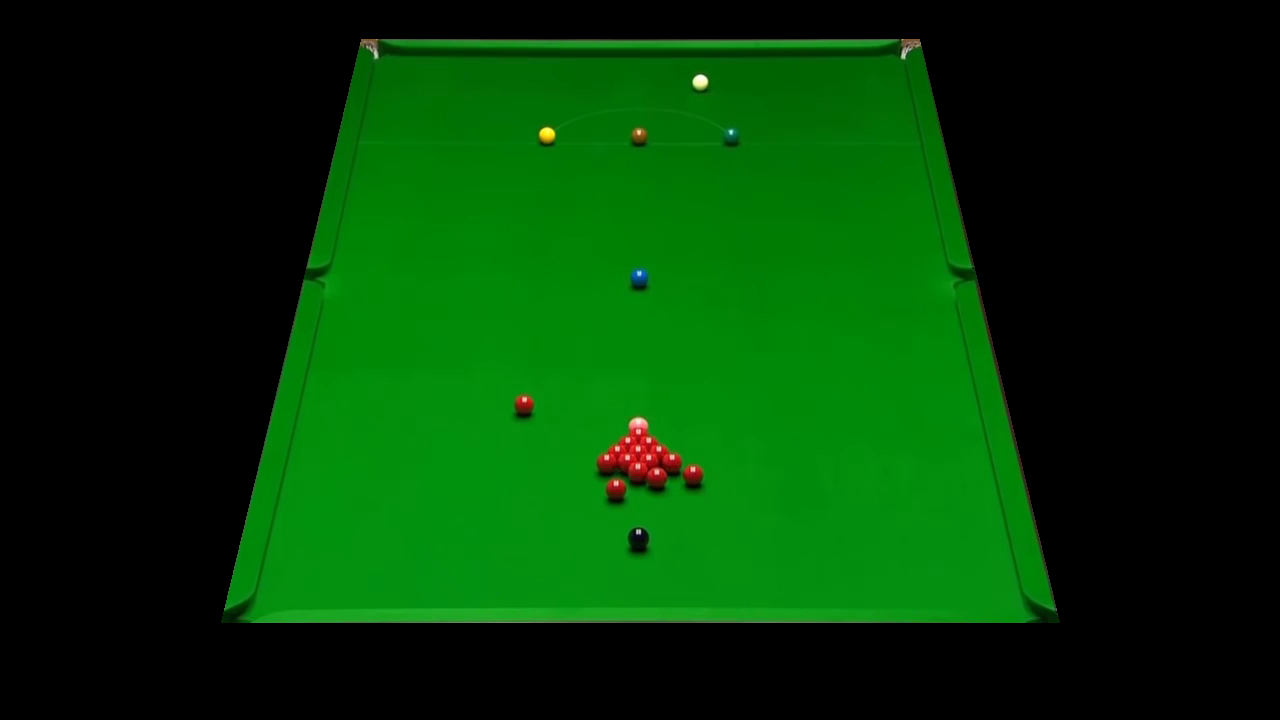

In [18]:
data_path = Path("data")
ref_frame_path = str(data_path / "WSC sample.png")

reference_frame = cv2.imread(ref_frame_path, cv2.IMREAD_COLOR)

# Find table boundaries and create a mask to hide irrelevant frame data
corners = table_edges_detection(reference_frame.copy())
mask = cv2.fillPoly(np.zeros(reference_frame.shape[:2], dtype=np.uint8), corners, 1)

# apply the mask
masked_frame = cv2.bitwise_and(reference_frame, reference_frame, mask=mask)
img_show(masked_frame)

# Find reference points (ball centers and baulk line)
centers = get_ball_centers(masked_frame)
(baulk_rho, baulk_theta) = detect_baulk_line(masked_frame)

Calculate the coordinates where the balls are placed on the table
$y = \frac{\rho - x\cos\theta}{\sin\theta}$

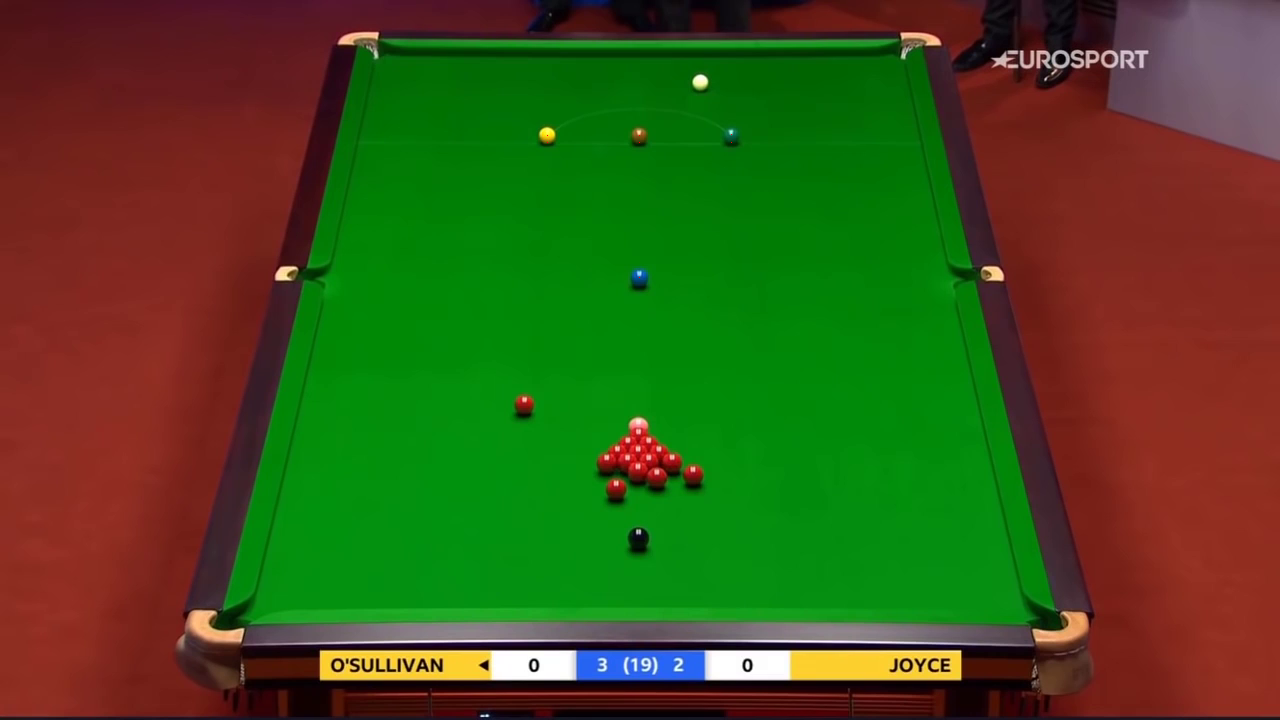

In [19]:
ground_points = {}
for color, (x, _) in centers.items():
    if color not in ["yellow", "brown", "green"]:
        continue

    y = (baulk_rho - x * np.cos(baulk_theta)) / np.sin(baulk_theta)
    ground_points[color + "_table"] = [x, int(y)]

image_points = centers | ground_points

for _, (x, y) in image_points.items():
    reference_frame[y, x] = (0, 0, 255)
img_show(reference_frame)

In [20]:
x_points = np.array(
    [
        image_points["yellow"],
        image_points["yellow_table"],
        image_points["brown"],
        image_points["brown_table"],
        image_points["green"],
        image_points["green_table"],
        image_points["blue"],
        # play area corners
        *corners[0],
    ]
)

# http://www.fcsnooker.co.uk/billiards/the_table_and%20table_markings.htm
# we are detecting the play area +2 inches for the cushions
X_points = np.array(
    [
        # balls
        [-0.292, 1.0475, 0.02625],  # yellow
        [-0.292, 1.0475, 0.0],  # yellow_table
        [0.0, 1.0475, 0.02625],  # brown
        [0.0, 1.0475, 0.0],  # brown_table
        [0.292, 1.0475, 0.02625],  # green
        [0.292, 1.0475, 0.0],  # green_table
        [0.0, 0.0, 0.02625],  # blue
        # play area + cushions corners
        [-0.934, 1.829, 0.03],  # top-left
        [0.934, 1.829, 0.03],  # top-right
        [0.934, -1.829, 0.03],  # bottom-right
        [-0.934, -1.829, 0.03],  # bottom-left
    ]
)

In [21]:
# DLT
P = DLT_normalized(X_points, x_points)
# P = DLT(X_points, x_points)
M = P[:, :3]  # Rotation matrix of the camera
camera = -np.linalg.inv(M).dot(P[:, 3].transpose())

In [22]:
# Prep rendering
w_world = 1.868
h_world = 3.658
h_img = reference_frame.shape[0]
scale = h_img / h_world
w_img = int(scale * w_world)
table = np.full((h_img, w_img, 3), PALETTE["table"], dtype=np.uint8)

baulk_line = int(scale * (-1.0475 + h_world / 2))
table[baulk_line] = PALETTE["white"]

# Process the video
processes filtered video frame by frame, computes ball centers and displays them.

In [27]:
# Video processing
video_path = data_path / "WSC.mp4"

filtered_path = video_path.with_name(
    video_path.stem + "_filtered" + video_path.suffix
)
# Create a filtered video if it doesn't exist (might take ~15mins)
if not filtered_path.exists():
    sample_score_tag = extract_score_tag(reference_frame)
    filter_video(video_path, filtered_path, sample_score_tag)

LIGHT_HARDCODED = [-3, 0, 6]

reader = VideoReader(filtered_path, max_count=10_000)

fps = reader.video.get(cv2.CAP_PROP_FPS)
shape = (
    int(reader.video.get(cv2.CAP_PROP_FRAME_WIDTH) + w_img),
    int(reader.video.get(cv2.CAP_PROP_FRAME_HEIGHT)),
)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(data_path / "result.mp4"), fourcc, fps, shape)

for frame in reader:
    masked_frame = cv2.bitwise_and(frame, frame, mask=mask)

    specular_out = detect_highlight(masked_frame)

    res = compute_ball_center_from_specular_reflection(
        P, camera, LIGHT_HARDCODED, specular_out
    )

    table_frame = draw_balls(table.copy(), res, scale, w_world, h_world)

    # display result
    display = np.concatenate((masked_frame, table_frame), axis=1)
    # writer.write(display)

    img_show(display)
    # cv2.imshow("Video", display)
    # window closing
    # key = cv2.waitKey(10)
    # if (
    #     cv2.getWindowProperty("Video", cv2.WND_PROP_VISIBLE) < 1  # window is closed
    #     or (key & 0xFF) == ord("q")
    # ):
    #     cv2.destroyAllWindows()
    #     break

writer.release()

Error openning video file
